In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import os,time,datetime,sys,random

### 1D Inviscid Euler Equation

$$
\begin{aligned}
&\partial_t U + \nabla\cdot f(U)=0, \quad  x\in\Omega\subset\mathbb{R},t\in(0,T] \\

& Loss = MSE_{\nabla\rho}+MSE_{p^*}+MSE_{F}\\

&\text{exact solution} \\
&\qquad U = (\rho,u,p) = (1+0.2\sin(\pi(x-t)),1,1)\\

\end{aligned}
$$


### PINNs Model

In [9]:
class PINN(tf.keras.Model):
    def __init__(
            self,
            t,x,dx,rho,rho_dx, # for density loss
            t_p,x_p,p, # for pressure loss
            t_r,x_r, # for residual loss (this is the innner point)
            in_dim,out_dim,width,depth,
            activ="tanh",w_init="glorot_normal",b_init="zeros",
            lr=1e-3,opt="Adam",info_seed=1234):
        super().__init__()
        # information
        self.info_seed = info_seed
        # initial the data
        self.data_type = tf.float32
        # density
        self.x = tf.convert_to_tensor(x,dtype=self.data_type)
        self.t = tf.convert_to_tensor(t,dtype=self.data_type)
        self.rho = tf.convert_to_tensor(rho,dtype=self.data_type)
        self.rho_dx = tf.convert_to_tensor(rho_dx,dtype=self.data_type)
        self.dx = dx
        # pressure
        self.p = tf.convert_to_tensor(p,dtype=self.data_type)
        self.x_p = tf.convert_to_tensor(x_p,dtype=self.data_type)
        self.t_p = tf.convert_to_tensor(t_p,dtype=self.data_type)
        # pde loss train point = inner + outer(initial+boundary)
        t_r = tf.concat([t,t_p,t_r],axis=0)
        x_r = tf.concat([x,x_p,x_r],axis=0)
        self.x_r = tf.convert_to_tensor(x_r,dtype=self.data_type)
        self.t_r = tf.convert_to_tensor(t_r,dtype=self.data_type)
        # neuron network configuration
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.width = width
        self.depth = depth
        self.activ = activ
        self.w_init = w_init
        self.b_init = b_init
        self.lr = lr
        self.opt = opt
        
        # call
        self.dnn = self.dnn_init(in_dim,out_dim,width,depth)
        self.params = self.dnn.trainable_variables
        self.optimizer = tf.keras.optimizers.Adam(learning_rate = self.lr, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)

        # track loss
        self.ep_log = []
        self.loss_log = []

        print(">>>>> start time:", datetime.datetime.now())
        print(">>>>> configuration;")
        print("         dtype        :", self.data_type)
        print("         activ func   :", self.activ)
        print("         weight init  :", self.w_init)
        print("         learning rate:", self.lr)
        print("         optimizer    :", self.opt)
        print("         summary      :", self.dnn.summary())
    
    def dnn_init(self,in_dim,out_dim,width,depth):
        net = tf.keras.Sequential()
        net.add(tf.keras.layers.InputLayer(in_dim))
        # net.add(tf.keras.layers.Lambda(lambda x: 2. * (x - self.lb) / (self.ub - self.lb) - 1.))
        for l in range(depth - 1):
            net.add(tf.keras.layers.Dense(units=width, activation = self.activ,kernel_initializer = self.w_init, bias_initializer = self.b_init, ))
        net.add(tf.keras.layers.Dense(out_dim))
        return net
    
    def loss_pde(self):
        with tf.GradientTape(persistent=True) as tp:
            tp.watch(self.t_r)
            tp.watch(self.x_r)
            u = self.dnn(tf.concat([self.t_r,self.x_r],1))
            rho = u[:,0][:,None]
            v = u[:,1][:,None]
            p = u[:,2][:,None]
        rho_t = tp.gradient(rho,self.t_r)
        v_t = tp.gradient(v,self.t_r)
        p_t = tp.gradient(p,self.t_r)
        rho_x = tp.gradient(rho,self.x_r)
        v_x = tp.gradient(v,self.x_r)
        p_x = tp.gradient(p,self.x_r)
        del tp
        equ_1 = rho_t + rho_x*v + rho*v_x
        equ_2 = (rho_t*v + rho*v_t) + (rho*(2*v*v_x) +(v**2)*rho_x + p_x)
        equ_3 = (5/2*p_t+1/2*rho_t*v*v+rho*v*v_t)+(v_x*(7/2*p+1/2*rho*v*v)+v*(7/2*p_x+1/2*rho_x*v*v+rho*v*v_x))
        r = tf.reduce_mean(tf.square(equ_1)+tf.square(equ_2)+tf.square(equ_3))
        return r

    def loss_rho(self):
        xdx = self.x+self.dx
        u = self.dnn(tf.concat([self.t,self.x],1))
        udx = self.dnn(tf.concat([self.t,xdx],1))
        loss = (self.rho_dx-self.rho)/self.dx-(udx[:,0][:,None]-u[:,0][:,None])/self.dx
        loss = tf.reduce_mean(tf.square(loss))
        return loss

    def loss_pressure(self):
        u = self.dnn(tf.concat([self.t_p,self.x_p],1))
        loss = tf.reduce_mean(tf.square(u[:,2][:,None] - self.p))
        return loss

    @tf.function
    def grad_desc(self):
        with tf.GradientTape() as tp:
            loss = self.loss_pde() + self.loss_rho() + self.loss_pressure()
        grad = tp.gradient(loss,self.params)
        del tp
        self.optimizer.apply_gradients(zip(grad,self.params))
        return loss
    
    def train(self,epoch,tol,info_freq):
        print(">>>>> training setting;")
        print("         # of epoch     :", epoch)
        print("         convergence tol:", tol)
        self.loss_pde()
        self.loss_rho()
        self.loss_pressure()
        t0 = time.time()
        for ep in range(epoch+1):
            ep_loss = self.grad_desc()
            if ep % info_freq ==0:
                elps = time.time() -t0
                self.ep_log.append(ep)
                self.loss_log.append(ep_loss)
                print("ep: %d, loss: %.3e, elps: %.3f" % (ep, ep_loss, elps))
                t0 = time.time()
            if ep_loss < tol:
                print(">>>>> end time:", datetime.datetime.now())
                break
        print(">>>>> end time:", datetime.datetime.now())

    def predict(self,t,x):
        t = tf.convert_to_tensor(t,dtype=self.data_type)
        x = tf.convert_to_tensor(x,dtype=self.data_type)
        with tf.GradientTape(persistent=True) as tp:
            tp.watch(t)
            tp.watch(x)
            u = self.dnn(tf.concat([t,x],1))
            rho = u[:,0][:,None]
            v = u[:,1][:,None]
            p = u[:,2][:,None]
        rho_t = tp.gradient(rho,t)
        v_t = tp.gradient(v,t)
        rho_x = tp.gradient(rho,x)
        v_x = tp.gradient(v,x)
        p_x = tp.gradient(p,x)
        del tp
        equ_1 = rho_t + rho_x*v + rho*v_x
        equ_2 = (rho_t*v + rho*v_t) + (rho*(2*v*v_x) +(v**2)*rho_x + p_x)
        loss = tf.reduce_mean(tf.square(equ_1)+tf.square(equ_2))
        return u,loss

### Structure of the Costum PINNs

In [10]:
in_dim = 2
out_dim = 3
width = 20
depth = 7

epoch = 12000
tol = 1e-8

N_rho = 800
dx = 0.008
N_p = 60
N_r = 2000

w_init = "glorot_normal"
b_init = "zeros"
act = "tanh"

lr = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate = 5e-3,
    decay_steps = epoch,
    alpha = 1e-2
)

opt = "Adam"
info_freq = 500
info_seed = 1234

print("python    :", sys.version)
print("tensorflow:", tf.__version__)
print("rand seed :", info_seed)
os.environ["PYTHONHASHSEED"] = str(info_seed)

python    : 3.9.13 (tags/v3.9.13:6de2ca5, May 17 2022, 16:36:42) [MSC v.1929 64 bit (AMD64)]
tensorflow: 2.9.1
rand seed : 1234


### 1D Inviscid Euler Equation

$$
\begin{aligned}
&\partial_t U + \nabla\cdot f(U)=0, \quad  x\in\Omega\subset\mathbb{R},t\in(0,T] \\

& Loss = MSE_{\nabla\rho}+MSE_{p^*}+MSE_{F}\\

&\text{exact solution} \\
&\qquad U = (\rho,u,p) = (1+0.2\sin(\pi(x-t)),1,1)\\

\end{aligned}
$$


In [11]:
tmin, tmax =  0., 1.
xmin, xmax = -1., 1.

t = tf.random.uniform((N_rho, 1), tmin, tmax, dtype = tf.float32)
x = tf.random.uniform((N_rho, 1), xmin, xmax, dtype = tf.float32)
rho = 1+0.2*tf.sin((x-t)*np.pi)
rho_dx = 1+0.2*tf.sin((x+dx-t)*np.pi)

t_p = tf.random.uniform((N_p, 1), tmin, tmax, dtype = tf.float32)
rd = random.random()
x_p = tf.convert_to_tensor([[rd] for x in t_p.numpy()],dtype=tf.float32)
p = tf.convert_to_tensor([[1.] for x in t_p.numpy()],dtype=tf.float32)

t_r = tf.random.uniform((N_r, 1), tmin, tmax, dtype = tf.float32)
x_r = tf.random.uniform((N_r, 1), xmin, xmax, dtype = tf.float32)

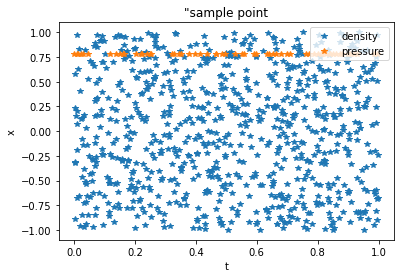

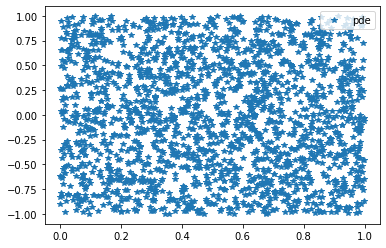

In [12]:
fig1,ax1 = plt.subplots(1)
ax1.set_xlabel('t')
ax1.set_ylabel('x')
ax1.set_title('"sample point')
ax1.plot(t.numpy().flatten(),x.numpy().flatten(),"*",label="density")
ax1.plot(t_p.numpy(),x_p,"*",label="pressure")
ax1.legend(loc="upper right")
fig2,ax2 = plt.subplots(1)
ax2.plot(t_r.numpy().flatten(),x_r.numpy().flatten(),"*",label="pde")
ax2.legend(loc="upper right")

In [13]:
pinn = PINN(t,x,dx,rho,rho_dx,
            t_p,x_p,p,
            t_r,x_r,
            in_dim,out_dim,width,depth,
            act,w_init,b_init,
            lr,opt,info_seed)

>>>>> start time: 2022-07-20 20:20:24.909465
>>>>> configuration;
         dtype        : <dtype: 'float32'>
         activ func   : tanh
         weight init  : glorot_normal
         learning rate: <keras.optimizers.schedules.learning_rate_schedule.CosineDecay object at 0x0000025F5E03CBB0>
         optimizer    : Adam
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 20)                60        
                                                                 
 dense_8 (Dense)             (None, 20)                420       
                                                                 
 dense_9 (Dense)             (None, 20)                420       
                                                                 
 dense_10 (Dense)            (None, 20)                420       
                                                              

In [14]:
pinn.train(epoch,tol,info_freq)

>>>>> training setting;
         # of epoch     : 12000
         convergence tol: 1e-08
ep: 0, loss: 2.245e+00, elps: 2.153
ep: 500, loss: 1.941e-04, elps: 4.976
ep: 1000, loss: 8.144e-05, elps: 5.399
ep: 1500, loss: 5.411e-05, elps: 5.111
ep: 2000, loss: 4.013e-05, elps: 5.783
ep: 2500, loss: 2.841e-05, elps: 5.836
ep: 3000, loss: 1.978e-05, elps: 6.126
ep: 3500, loss: 1.206e-05, elps: 6.672
ep: 4000, loss: 6.980e-06, elps: 6.333
ep: 4500, loss: 3.749e-05, elps: 6.013
ep: 5000, loss: 2.504e-04, elps: 6.121
ep: 5500, loss: 2.526e-06, elps: 6.365
ep: 6000, loss: 7.825e-06, elps: 6.138
ep: 6500, loss: 1.778e-06, elps: 6.097
ep: 7000, loss: 6.525e-06, elps: 6.117
ep: 7500, loss: 1.294e-06, elps: 6.146
ep: 8000, loss: 1.458e-06, elps: 6.152
ep: 8500, loss: 8.943e-07, elps: 6.146
ep: 9000, loss: 7.963e-07, elps: 6.221
ep: 9500, loss: 7.413e-07, elps: 6.129
ep: 10000, loss: 6.995e-07, elps: 6.188
ep: 10500, loss: 6.682e-07, elps: 6.337
ep: 11000, loss: 6.454e-07, elps: 6.517
ep: 11500, loss:

### Visualization

In [15]:
def plot_loss(x,y,title,savepath="./pics"):

    fig1,ax1 = plt.subplots(1)
    ax1.plot(x,y)
    ax1.grid(alpha=0.5)
    ax1.set_ylabel("loss")
    ax1.set_xlabel("epoch")
    ax1.set_title("train loss")

    fig2,ax2 = plt.subplots(1)
    ax2.plot(x,y)
    ax2.grid(alpha=0.5)
    ax2.set_ylabel("loss")
    ax2.set_xlabel("epoch")
    ax2.set_yscale("log")
    ax2.set_title("train loss(log)")

    fig3,ax3 = plt.subplots(1)
    strt = int(len(x)*0.7)
    ax3.plot(x[strt:],y[strt:])
    ax3.grid(alpha=0.5)
    ax3.set_xlabel("epoch")
    ax3.set_ylabel("loss")
    
    ax3.set_title("train loss(part)")

    if not os.path.exists(savepath):
        os.makedirs(savepath)
    fig1.savefig(savepath+"/"+title)
    fig2.savefig(savepath+"/"+title+"(log)")
    fig3.savefig(savepath+"/"+title+"(part")


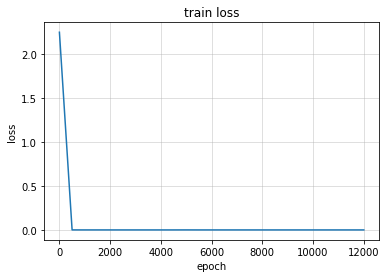

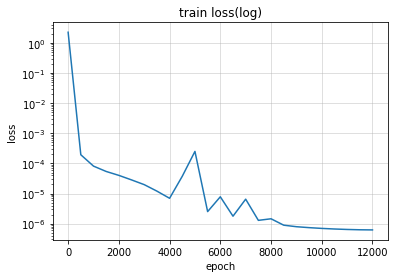

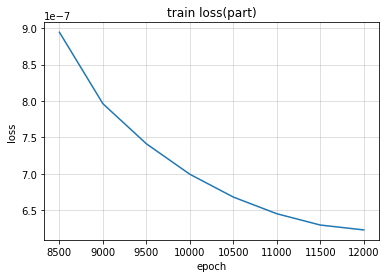

In [16]:
plot_loss(pinn.ep_log,pinn.loss_log,"loss")

In [17]:
def plot_solution(X,u,savepath="./pics"):
    lb = X.min(0)
    ub = X.max(0)
    x = np.linspace(lb[0],ub[0],200)
    y = np.linspace(lb[1],ub[1],200)
    x,y = np.meshgrid(x,y)
    phi_1 = griddata(X,u[:,0].numpy().flatten(),(x,y),method="linear")
    phi_2 = griddata(X,u[:,1].numpy().flatten(),(x,y),method="linear")
    phi_3 = griddata(X,u[:,2].numpy().flatten(),(x,y),method="linear")
    
    if not os.path.exists(savepath):
        os.makedirs(savepath)
    plt.imshow(phi_1,interpolation='nearest',cmap='rainbow',extent=[0,1,-1,1],origin="lower",aspect="auto")
    plt.colorbar()
    plt.title("density prediction")
    plt.xlabel('t')
    plt.ylabel('x')
    plt.savefig(savepath+"/density prediction")

    plt.imshow(phi_2,interpolation='nearest',cmap='rainbow',extent=[0,1,-1,1],origin="lower",aspect="auto")
    plt.colorbar()
    plt.title("velocity prediction")
    plt.xlabel('t')
    plt.ylabel('x')
    plt.savefig(savepath+"/velocity prediction")

    plt.imshow(phi_3,interpolation='nearest',cmap='rainbow',extent=[0,1,-1,1],origin="lower",aspect="auto")
    plt.colorbar()
    plt.title("pressure prediction")
    plt.xlabel('t')
    plt.ylabel('x')
    plt.savefig(savepath+"/pressure prediction")
    

In [18]:
def plot_final(X,u,final_t,savepath="./pics"):
    if not os.path.exists(savepath):
        os.makedirs(savepath)
    index = np.array([ [i,x[1]] for i,x in enumerate(TX) if x[0]==final_t])
    density = [u[:,0][int(i)] for i in index[:,0]]
    velocity = [u[:,1][int(i)] for i in index[:,0]]
    pressure = [u[:,2][int(i)] for i in index[:,0]]
    xx = index[:,1]

    plt.figure(figsize=(8,6))
    plt.title(f"density(t={final_t})")
    plt.xlabel('x')
    plt.ylabel('density')
    plt.plot(xx,density,label="NN")
    plt.plot(xx,1.0+0.2*np.sin(np.pi*(xx-final_t)),label='exact')
    plt.legend(loc="upper right")
    plt.savefig(f"{savepath}/density(t={final_t}).png")

    plt.figure(figsize=(8,6))
    plt.title(f"velocity(t={final_t})")
    plt.xlabel('x')
    plt.ylabel('velocity')
    plt.plot(xx,velocity,label="NN")
    plt.plot(xx,np.ones(len(xx)),label="exact")
    plt.legend(loc="upper right")
    plt.ylim(0.95,1.05)
    plt.savefig(f"{savepath}/velocity(t={final_t}.png")

    plt.figure(figsize=(8,6))
    plt.title(f"pressure(t={final_t})")
    plt.xlabel('x')
    plt.ylabel('pressure')
    plt.plot(xx,pressure,label="NN")
    plt.plot(xx,np.ones(len(xx)),label="exact")
    plt.legend(loc="upper right")
    plt.ylim(0.95,1.05)
    plt.savefig(f"{savepath}/pressure(t={final_t}).png")

In [19]:
t = np.linspace(tmin,tmax,1001)
x = np.linspace(xmin,xmax,101)
t,x = np.meshgrid(t,x)
t = t.reshape(-1, 1)
x = x.reshape(-1, 1)
TX = np.c_[t,x]

In [20]:
u,r = pinn.predict(t,x)

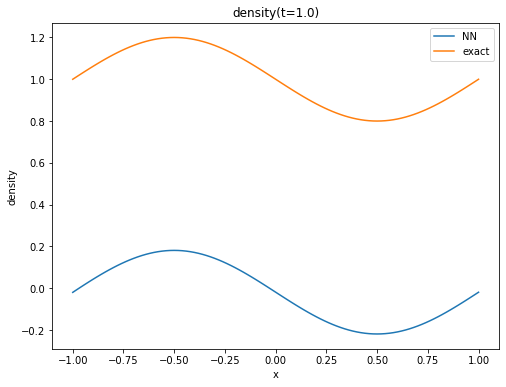

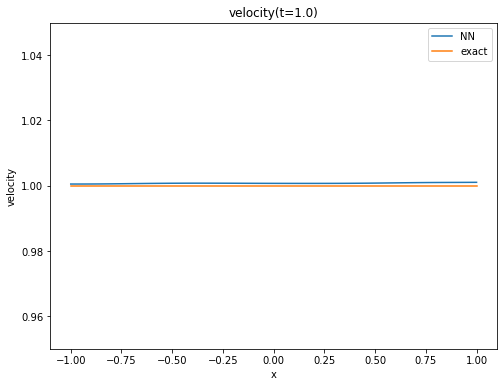

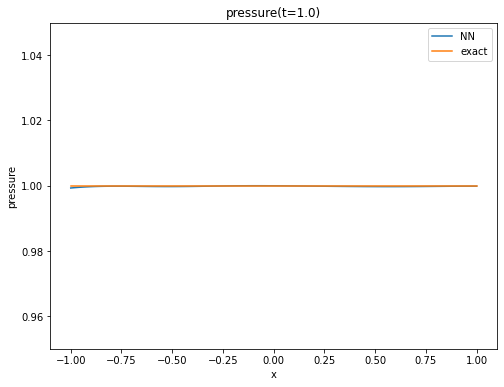

In [21]:
plot_final(TX,u,tmax)

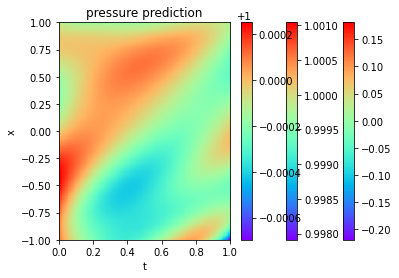

In [22]:
plot_solution(TX,u)